# Import libraries and modules

In [65]:
# Reload modules before executing user code
%load_ext autoreload
%autoreload 2

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat

# Find current directory
current_dir = os.getcwd()
# Find root directory
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
# Add root directory to path
sys.path.append(root_dir)

print(f"Current directory: {current_dir}")
print(f"Root directory: {root_dir}")

from pysindy.utils.odes import linear_damped_SHO
import pysindy.pysindy as ps

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['method'] = 'RK23'   #'LSODA'
integrator_keywords['rtol'] = 1e-3
integrator_keywords['atol'] = 1e-6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current directory: /media/jesus/GSUS-DATA/CANADA_docs/RaymondSpiteri_USASK_SK/SINDy/pysindy_fork/simlab_experiments
Root directory: /media/jesus/GSUS-DATA/CANADA_docs/RaymondSpiteri_USASK_SK/SINDy/pysindy_fork


# Functions

In [66]:
def readExpData(file_path, Nsize=100):
    
    if os.path.isfile(file_path):
        
        # extract data from file using numpy module
        data = np.loadtxt(file_path)
        size = np.shape(data)

        t_data = np.empty(shape=(size[0],))
        # first column of the file is time
        t_data[:] = data[:, 0]

        # remaining data is number of clusters of size n. Index for column i corresponds to number of clusters of size i-1
        # n_data = data[:, 1:Nsize+1]
        #** We just divide the cluster numbers by the volume of the system which is 126^3 (in units of sigma). 
        n_data = data[:, 1:Nsize+1] / (126**3)  ## only the first 'size' (excluding the very first 0) entries to match the kappa coeff
        
        return t_data, n_data
    
    else:
        print(f"Experiment file ({file_path}) does not exist")
        exit()

# Load data

In [67]:
experiment_dir = 'data'
experiment_file = 'Population_Training_Results.dat'
exp_dir = os.path.join(experiment_dir, experiment_file)
system_size = 50
n_samples_train = 5000
n_samples_test = 100

t_values, N_clusters = readExpData(exp_dir, Nsize=system_size)

# n_samples_train random indices
indices = np.random.choice(len(t_values), n_samples_train, replace=False)
indices = np.sort(indices)
N_clusters_train = N_clusters[indices]
t_values_train = t_values[indices]

In [68]:
indices

array([    0,     1,     3, ..., 16248, 16249, 16251])

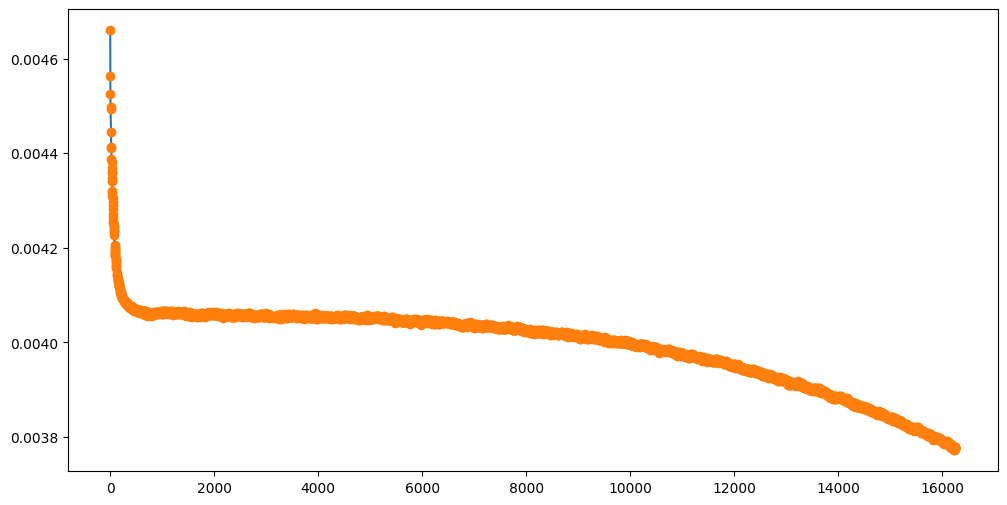

In [69]:
n_to_plot = 1

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(t_values, N_clusters[:, n_to_plot-1], label=f'Cluster size {n_to_plot}')
# plt.plot(t_values[:n_samples_train], N_clusters[:n_samples_train, n_to_plot-1], label=f'Cluster size {n_to_plot}')
plt.plot(t_values_train, N_clusters_train[:, n_to_plot-1], 'o', label=f'Training data Cluster size {n_to_plot}')

plt.show()

# Build and fit the model

In [70]:
# Fit the model

poly_order = 2
threshold = 1e-10
dt = 1

model = ps.SINDy( 
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(N_clusters_train, t=dt)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(),
      feature_names=['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
                     'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17',
                     'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25',
                     'x26', 'x27', 'x28', 'x29', ...],
      optimizer=STLSQ(threshold=1e-10))

In [71]:
# Print the model
# model.print()

save_folder = 'ck_experiments'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
    
model.save(save_folder, precision=4)

In [72]:
model.coefficients()

array([[-5.65668869e-05,  2.24464829e-02,  1.02557338e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.28579293e-04,  2.52216062e-01, -8.83167762e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.52488827e-05, -2.50891254e-02,  2.21889644e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [73]:
n_sim, t_sim = model.simulate(N_clusters[0], t=t_values[:n_samples_test], integrator_kws=integrator_keywords)

In [74]:
n_sim.shape, t_sim.shape

((100, 50), (100,))

In [75]:
t_values.shape, N_clusters.shape, n_sim.shape

((16257,), (16257, 50), (100, 50))

/tmp/ipykernel_289437/2532046506.py:11: RuntimeWarning: divide by zero encountered in log
  t_values_log = np.log(t_values)
/tmp/ipykernel_289437/2532046506.py:12: RuntimeWarning: divide by zero encountered in log
  t_sim_log = np.log(t_sim)


Cluster size 100 is larger than the system size 50


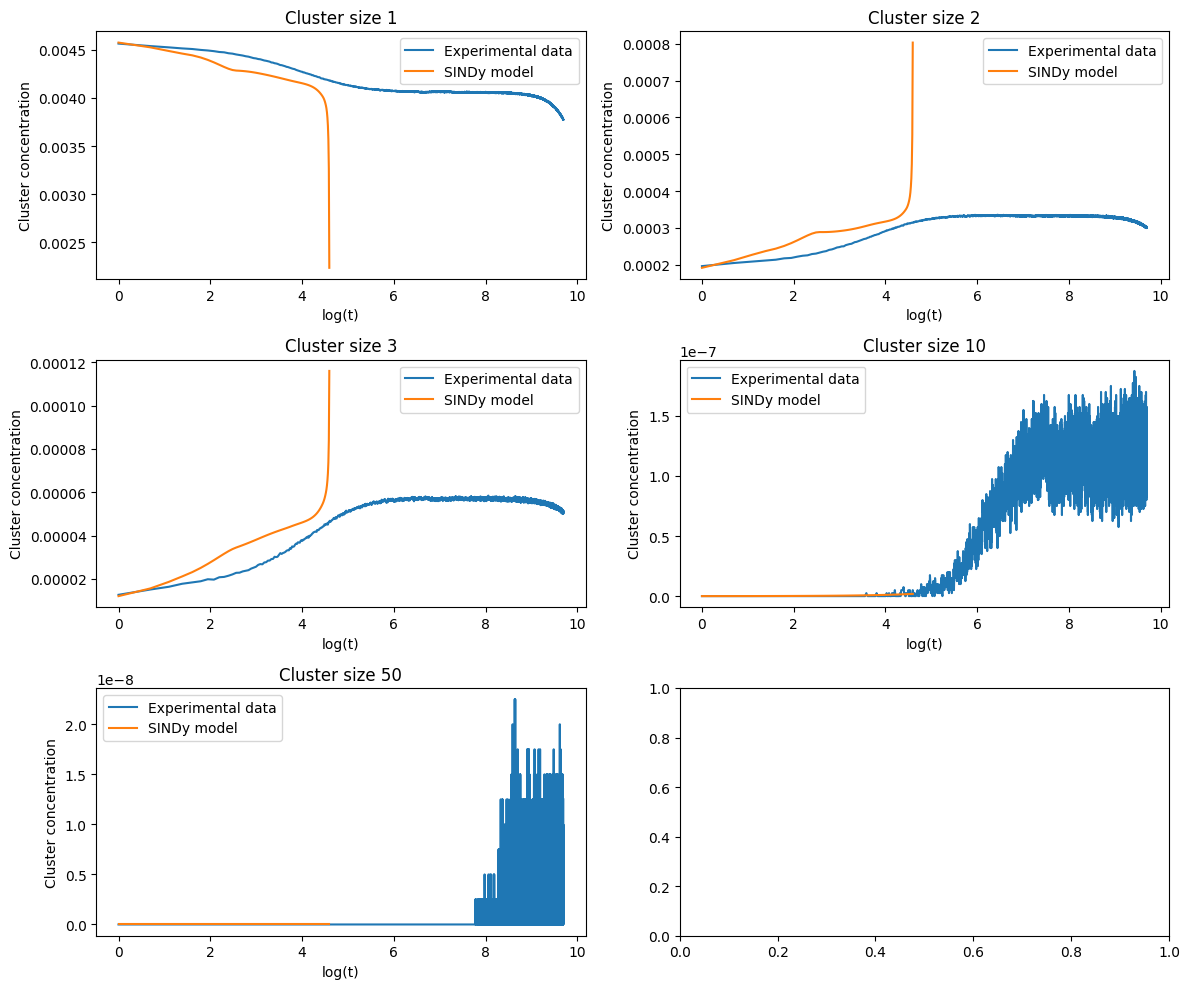

In [77]:
# List of IDs to plot
ids_to_plot = [1, 2, 3, 10, 50, 100]

# Create subplot grid
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Log the time values
t_values_log = np.log(t_values)
t_sim_log = np.log(t_sim)

for i, n_to_plot in enumerate(ids_to_plot):
    
    if n_to_plot > system_size:
        print(f"Cluster size {n_to_plot} is larger than the system size {system_size}")
        continue
    # Plot the data
    axs[i].plot(t_values_log, N_clusters[:, n_to_plot-1], label=f'Experimental data')
    axs[i].plot(t_sim_log, n_sim[:, n_to_plot-1], label='SINDy model')
    axs[i].set_title(f'Cluster size {n_to_plot}')
    axs[i].legend()
    
    axs[i].set_xlabel('log(t)')
    axs[i].set_ylabel('Cluster concentration')

plt.tight_layout()
plt.show()